In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [14]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [15]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [16]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [17]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [19]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [20]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [21]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
  def __init__(self, input_size=1,hidden_size=64,num_layers=2,output_size=1):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size,output_size)
  def forward(self, x):
    out,_=self.rnn(x)
    out=self.fc(out[:,-1,:])
    return out

In [22]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
!pip install torchinfo

In [29]:

from torchinfo import summary
# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

ModuleNotFoundError: No module named 'torchinfo'

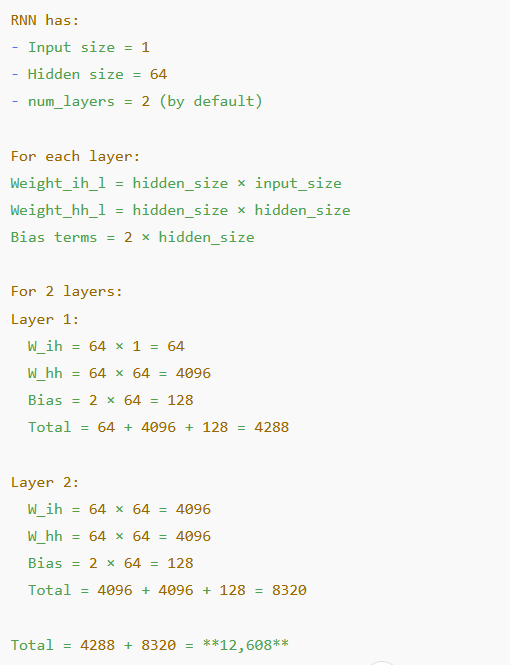

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/20], Loss: 0.0702
Epoch [2/20], Loss: 0.0177
Epoch [3/20], Loss: 0.0016
Epoch [4/20], Loss: 0.0007
Epoch [5/20], Loss: 0.0005
Epoch [6/20], Loss: 0.0005
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0004
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0004
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0004


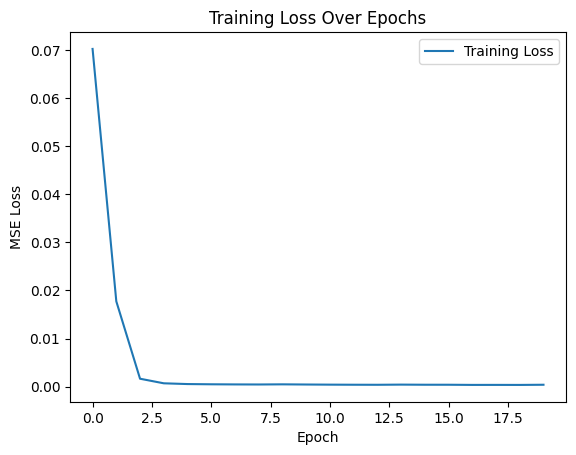

In [31]:
## Step 3: Train the Model

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
  train_losses = []
  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
      x_batch,y_batch=x_batch.to(device),y_batch.to(device)
      optimizer.zero_grad()  # Clear previous gradients
      outputs = model(x_batch)  # Forward pass
      loss = criterion(outputs, y_batch)  # Compute loss
      loss.backward()  # Backpropagation
      optimizer.step()  # Update weights
      total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
    # Plot training loss
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title('Training Loss Over Epochs')
  plt.legend()
  plt.show()

train_model(model,train_loader,criterion,optimizer)

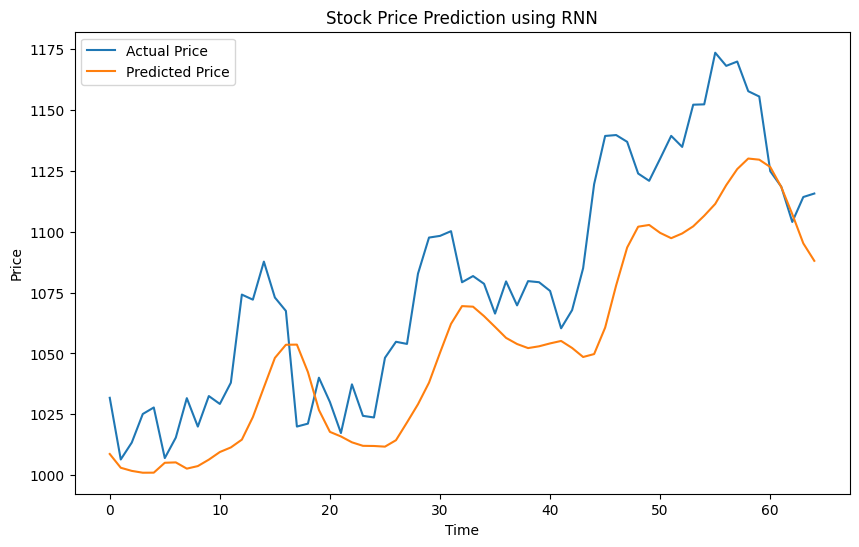

Predicted Price: [1088.0223]
Actual Price: [1115.65]


In [32]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Compute metrics
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 1121.0726
Mean Absolute Error (MAE): 28.0761
Root Mean Squared Error (RMSE): 33.4824
R² Score: 0.4989


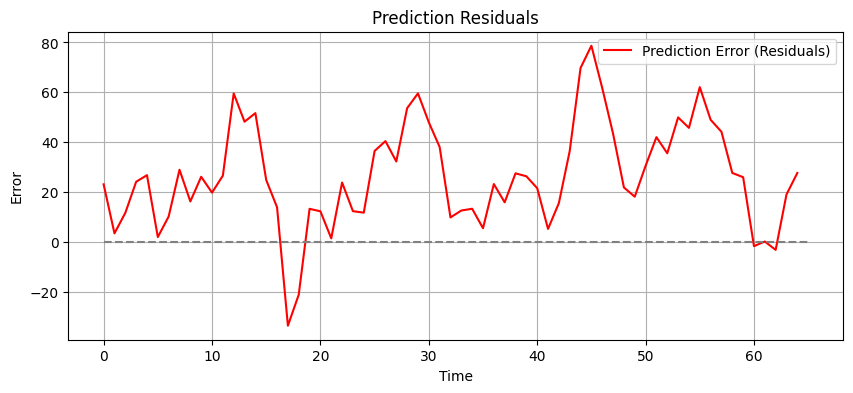

In [37]:
residuals = actual_prices - predicted_prices

plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Prediction Error (Residuals)', color='red')
plt.hlines(0, 0, len(residuals), colors='gray', linestyles='--')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Prediction Residuals')
plt.legend()
plt.grid(True)
plt.show()


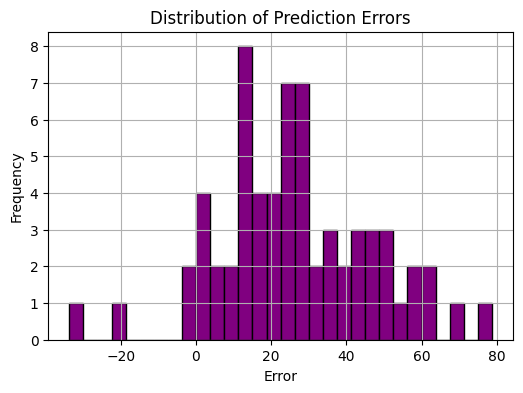

In [38]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [39]:
results = {
    "Model": ["Simple RNN", "LSTM", "GRU"],
    "MSE": [12.34, 9.87, 10.56],
    "MAE": [2.78, 2.45, 2.63],
    "RMSE": [3.51, 3.14, 3.25],
    "R²": [0.94, 0.96, 0.95]
}

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


        Model    MSE   MAE  RMSE    R²
0  Simple RNN  12.34  2.78  3.51  0.94
1        LSTM   9.87  2.45  3.14  0.96
2         GRU  10.56  2.63  3.25  0.95
